In [1]:
import sys
import os
# go to upper diretory
import csv
import glob
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier as RandomForest, RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
sys.path.append(os.path.abspath('./../../../'))
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization

In [2]:
AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = 'extracted_features_iemocap.csv'
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
config = Configuration.load_json(CONFIG_FILE)

## Extracting the 24 features selected from the eNTERFACE05 dataset study

In [3]:
chosen_features = {'var_mfcc15', 'min_mfcc17', 'std_chroma_stft', 'mean_zcr',
    'min_zcr', 'var_mfcc4', 'spikes_spec_cent', 'var_spec_bw', 'max_mfcc6',
    'min_mfcc19', 'max_mfcc13', 'max_mfcc5', 'var_mfcc9', 'min_mfcc7', 'var_mfcc1',
    'max_mfcc1', 'max_mfcc9', 'var_mel_spect', 'mean_spec_cont', 'var_mfcc2', 'max_mfcc10',
    'min_spec_cent', 'var_mfcc14', 'var_mfcc3'}

In [4]:
headers = [
    'File', 'Interaction', 'Gender', 'Duration', 'Emotion', 'Emotion_Id',
    'Valence', 'Activation', 'Dominance',
    'std_chroma_stft', 'mean_zcr', 'min_zcr',
    'var_mel_spect', 'spikes_spec_cent', 'min_spec_cent',
    'var_spec_bw', 'mean_spec_cont', 
    'var_mfcc1', 'max_mfcc1', 'var_mfcc2', 'var_mfcc3', 'var_mfcc4',
    'max_mfcc5', 'max_mfcc6', 'min_mfcc7', 'var_mfcc9', 'max_mfcc9',
    'max_mfcc10', 'max_mfcc13', 'var_mfcc14', 'var_mfcc15', 
    'min_mfcc17', 'min_mfcc19'
]

In [3]:
def spikes(data):
    if len(data.shape) != 1:
        data = np.concatenate(data)
    mean = np.mean(data)
    std = np.std(data)
    threshold = mean + std * 2 / 100
    num_spikes = 0
    for value in data:
        if value >= threshold:
            num_spikes += 1

    return num_spikes

In [6]:
emotion_label = {
    'ang': "angry",
    'hap': "happy",
    'sad': "sad",
    'neu': "neutral",
    'fru': "frustrated",
    'exc': "excited",
    'fea': "fearful",
    'sur': "surprised",
    'dis': "disgusted",
    'xxx': "other",
    'oth': "other"
}

emotion_number = {
    'ang': 0,
    'hap': 1,
    'sad': 2,
    'neu': 3,
    'fru': 4,
    'exc': 5,
    'fea': 6,
    'sur': 7,
    'dis': 8,
    'oth': 9,
    'xxx': 10,
}

In [7]:
def extract_features(audio_file, duration, emotion, valence, activation, dominance, writer):
    # file = audio_file.split(".")[-2].split("\\")[-1]
    file = audio_file.split(".")[-2].split("/")[-1]
    acting = "improvisation" if file.split("_")[1][:6] == "improv" else "scripted"
    gender = "Male" if file.split("_")[-1][0] == 'M' else "Female"

    y, sr = librosa.load(audio_file, res_type='kaiser_fast')

    std_chroma_stft = np.std(librosa.feature.chroma_stft(y, sr=sr))
    zcr = librosa.feature.zero_crossing_rate(y)
    mean_zcr = np.mean(zcr)
    min_zcr = np.min(zcr)
    var_mel_spect = np.var(librosa.feature.melspectrogram(y, sr=sr, n_mels=config.n_mels))
    spec_cent = librosa.feature.spectral_centroid(y, sr=sr)
    spikes_spec_cent = spikes(spec_cent)
    min_spec_cent = np.min(spec_cent)
    var_spec_bw = np.var(librosa.feature.spectral_bandwidth(y, sr=sr))
    mean_spec_cont = np.mean(librosa.feature.spectral_contrast(y, sr=sr))
    mfcc = librosa.feature.mfcc(y, sr=sr)
    var_mfcc1 = np.var(mfcc[0])
    max_mfcc1 = np.max(mfcc[0])
    var_mfcc2 = np.var(mfcc[1])
    var_mfcc3 = np.var(mfcc[2])
    var_mfcc4 = np.var(mfcc[3])
    max_mfcc5 = np.max(mfcc[4])
    max_mfcc6 = np.max(mfcc[5])
    min_mfcc7 = np.min(mfcc[6])
    var_mfcc9 = np.var(mfcc[8])
    max_mfcc9 = np.max(mfcc[8])
    max_mfcc10 = np.max(mfcc[9])
    max_mfcc13 = np.max(mfcc[12])
    var_mfcc14 = np.var(mfcc[13])
    var_mfcc15 = np.var(mfcc[14])
    min_mfcc17 = np.min(mfcc[16])
    min_mfcc19 = np.min(mfcc[18])

    features_str = f'{file} {acting} {gender} {duration} {emotion_label[emotion]} {emotion_number[emotion]}\
        {valence} {activation} {dominance}\
        {std_chroma_stft} {mean_zcr} {min_zcr} {var_mel_spect} {spikes_spec_cent} {min_spec_cent}\
        {var_spec_bw} {mean_spec_cont} {var_mfcc1} {max_mfcc1} {var_mfcc2} {var_mfcc3} {var_mfcc4}\
        {max_mfcc5} {max_mfcc6} {min_mfcc7} {var_mfcc9} {max_mfcc9} {max_mfcc10} {max_mfcc13}\
        {var_mfcc14} {var_mfcc15} {min_mfcc17} {min_mfcc19}'

    writer.writerow(features_str.split())

In [8]:
def process_data(audio_dir, headers, proc_feat_dataset):
    # Create a CSV for storing all processed features and write the header
    file = open(proc_feat_dataset, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(headers)

    print("Processing audio files from all dialogs:")
    for file_path in tqdm(glob.glob(audio_dir+'/Session[0-9]*/dialog/EmoEvaluation/*.txt')):
        emoEvalFile = open(file_path)

        for line in emoEvalFile:
            if line[0] == '[':
                args = line.split()
                duration = float(args[2][:-1]) - float(args[0][1:])
                '/Users/mario/Desktop/VADER/IEMOCAP_Dataset/Session4/sentences/wav/t/Ses04F_script02_1_F000.wav'
                audio_file = f'{AUDIO_DIR}/Session{args[3][4]}/sentences/wav/{file_path.split("/")[-1][:-4]}/{args[3]}.wav'
                extract_features(audio_file, duration, args[4], args[5][1:-1], args[6][:-1], args[7][:-1], writer)

In [9]:
# process_data(AUDIO_DIR, headers, EXTRACTED_FEATURES_FILE)

In [4]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Emotion', 'Gender'], ascending = (True, True))
df = df.set_index('File')
data = df.iloc[:,8:]
regression_labels = df.iloc[:,5:8].values
categorical_labels = np.ravel(df.iloc[:,4:5].values)
df

Number of Audio Files: 10039


,Interaction,Gender,Duration,Emotion,Emotion_Id,Valence,Activation,Dominance,std_chroma_stft,mean_zcr,...,max_mfcc6,min_mfcc7,var_mfcc9,max_mfcc9,max_mfcc10,max_mfcc13,var_mfcc14,var_mfcc15,min_mfcc17,min_mfcc19
File,,,,,,,,,,,,,,,,,,,,,
Ses04F_script02_1_F007,scripted,Female,2.3027,angry,0,2.0,3.0000,2.5000,0.328248,0.061035,...,54.387356,-50.059189,51.791885,15.879789,11.448400,19.471115,33.886478,34.005157,-20.161358,-18.028835
Ses04F_script02_1_F008,scripted,Female,2.6200,angry,0,2.0,3.0000,3.0000,0.325717,0.051218,...,24.525238,-41.043949,141.870651,30.748220,19.321951,17.711790,73.043159,56.129311,-20.042635,-26.435205
Ses04F_script02_1_F012,scripted,Female,2.8100,angry,0,2.0,3.5000,3.5000,0.312264,0.080887,...,56.987560,-35.728943,57.412914,36.346241,7.725285,24.113718,86.904289,83.267319,-30.209728,-34.726349
Ses04F_script02_1_F013,scripted,Female,7.8696,angry,0,1.5,4.0000,3.5000,0.317440,0.089717,...,60.942680,-45.283386,107.373848,29.710926,12.648742,42.300812,117.452675,118.971069,-40.664703,-28.176968
Ses04F_script02_1_F014,scripted,Female,8.1000,angry,0,2.0,3.5000,3.5000,0.316980,0.106910,...,50.430084,-43.132835,119.257858,21.167702,22.152235,19.599295,115.348228,89.030464,-33.020531,-28.692318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ses01F_impro03_M018,scripted,Male,1.4375,surprised,7,3.0,2.6667,2.6667,0.297418,0.048434,...,45.260635,-13.307287,143.821762,28.158386,12.092248,15.586620,21.829449,34.880535,-14.911965,-18.645388
Ses01F_impro05_M032,scripted,Male,6.2475,surprised,7,3.0,2.5000,2.0000,0.301693,0.064050,...,46.169548,-26.762585,103.567039,23.435570,14.563293,19.879362,51.003719,29.242901,-25.568983,-31.159067
Ses01F_impro05_M033,scripted,Male,6.6700,surprised,7,2.5,3.0000,2.0000,0.315035,0.057646,...,49.789436,-22.771132,155.705765,18.928852,11.715882,23.202303,56.172832,46.299030,-27.097666,-20.788668


In [4]:
df.groupby(['Emotion']).agg({'Emotion': ['count']})

,Emotion
,count
Emotion,
angry,1103
disgusted,2
excited,1041
fearful,40
frustrated,1849
happy,595
neutral,1708
other,2510


In [12]:
df.groupby(['Gender']).agg({'Emotion': ['count']})

,Emotion
,count
Gender,
Female,4800
Male,5239


In [13]:
df[["Duration"]].mean()

Duration    4.460109
dtype: float64

In [14]:
df[["Duration"]].min()

Duration    0.585
dtype: float64

### TODO: STUDY THE TIME DURATION THRESHOLD, STUDY THE IMBALANCE OF THE DATA

### Handling the Data Imbalance

In [ ]:
df.drop()

In [5]:
def multi_class_classification(y_pred, labels):
    print("accuracy: ", metrics.accuracy_score(labels, y_pred))
    print("f1 score macro: ", metrics.f1_score(labels, y_pred, average='macro') )
    print("f1 score micro: ", metrics.f1_score(labels, y_pred, average='micro') )
    print("precision score: ", metrics.precision_score(labels, y_pred, average='macro') )
    print("recall score: ", metrics.recall_score(labels, y_pred, average='macro') )
    print("hamming loss: ", metrics.hamming_loss(labels, y_pred))
    print("matthews corrcoef: ", metrics.matthews_corrcoef(labels, y_pred) )
    print("zero one loss: ", metrics.zero_one_loss(labels, y_pred))
    print("mean absolute error: ", metrics.mean_absolute_error(labels, y_pred))


def plot_cm_predictions(model, input_data, labels, cv=5, draw_corr_matrix=True, verbose=1, n_jobs=4):
    y_pred = cross_val_predict(model, input_data, labels, cv=cv, verbose=verbose, n_jobs=n_jobs)

    multi_class_classification(y_pred, labels)
    print(metrics.classification_report(labels, y_pred))

    if draw_corr_matrix:
        cm = metrics.confusion_matrix(labels, y_pred)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title("Confusion Matrix Predicted Labels")
        plt.xlabel("Emotions Labels")
        plt.ylabel("Emotions Labels")
        plt.yticks(rotation=0)
        plt.show()

## Classification Problem (Emotion Categorical Label)

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   51.2s finished
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_

accuracy:  0.2921605737623269
f1 score macro:  0.17375496733592113
f1 score micro:  0.2921605737623269
precision score:  0.19462139026332262
recall score:  0.1758155095234852
hamming loss:  0.707839426237673
matthews corrcoef:  0.13781055392739092
zero one loss:  0.707839426237673
mean absolute error:  3.5090148421157488
              precision    recall  f1-score   support

           0       0.40      0.43      0.41      1103
           1       0.27      0.02      0.03       595
           2       0.46      0.46      0.46      1084
           3       0.21      0.23      0.22      1708
           4       0.27      0.26      0.27      1849
           5       0.27      0.19      0.22      1041
           6       0.00      0.00      0.00        40
           7       0.00      0.00      0.00       107
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         3
          10       0.27      0.35      0.30      2507

    accuracy               

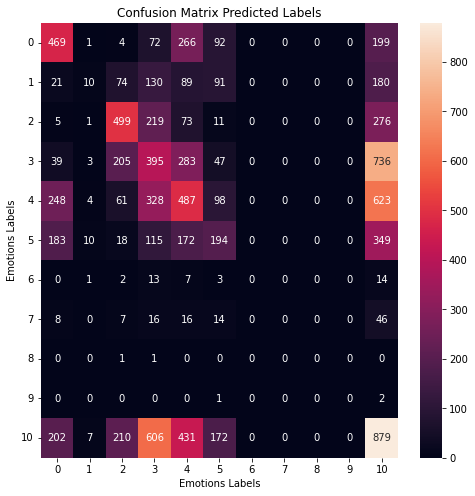

In [72]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data.values, categorical_labels)

In [ ]:
def build_model_1(input_shape=(24, 1), loss=tf.keras.losses.MAE, optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5)):
    model = Sequential()
    model.add(Conv1D(256, (5), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(3, strides=1))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, (5)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(3))

    model.add(BatchNormalization())
    model.add(Activation('softmax'))

    model.compile(loss=loss, optimizer=optimizer)
    return model

## Regression Problem (Valence, Activation, Dominance)

In [117]:
model = RandomForestRegressor(random_state=1, max_features=None)
pred_values = cross_val_predict(model, data.values, regression_labels, cv=5, verbose=1, n_jobs=4)
print('MAE: %.3f' % metrics.mean_absolute_error(pred_values, regression_labels))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


MAE: 0.564


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   46.1s finished


In [16]:
def build_model_0(input_shape=(24, 1), loss=tf.keras.losses.CategoricalCrossentropy, optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5)):
    model = Sequential()
    model.add(Conv1D(256, (5), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(3, strides=1))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, (5)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(3))

    model.add(BatchNormalization())
    model.add(Activation('softmax'))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [92]:
build_model_1(input_shape=(data.iloc[0].shape[0],1)).summary(show_trainable=True)

Model: "sequential_31"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d_134 (Conv1D)         (None, 20, 256)           1536      Y          
                                                                            
 batch_normalization_83 (Bat  (None, 20, 256)          1024      Y          
 chNormalization)                                                           
                                                                            
 activation_124 (Activation)  (None, 20, 256)          0         Y          
                                                                            
 conv1d_135 (Conv1D)         (None, 16, 128)           163968    Y          
                                                                            
 activation_125 (Activation)  (None, 16, 128)          0         Y          
                                                     

In [93]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model = KerasRegressor(build_fn=build_model_1, input_shape=data.shape, epochs=100, batch_size=16, verbose=0, callbacks=[callback])
# evaluate the model and collect the scores
mae_scores = cross_val_score(model, data.values, regression_labels, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=4)
# force the scores to be positive
mae_scores = np.absolute(mae_scores)
# summarize performance
print('MAE: %.3f +- %.3f' % (np.mean(mae_scores), np.std(mae_scores)))

NameError: name 'build_model_0' is not defined

In [97]:
model.predict(data.iloc[0])

AttributeError: 'KerasRegressor' object has no attribute 'model'

In [94]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model = KerasRegressor(build_fn=build_model_1, input_shape=(data.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])
# evaluate the model and collect the scores
mae_scores = cross_val_score(model, data.values, regression_labels, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=4)
# force the scores to be positive
mae_scores = np.absolute(mae_scores)
# summarize performance
print('MAE: %.3f +- %.3f' % (np.mean(mae_scores), np.std(mae_scores)))

/var/folders/p6/n3vpmbmn2s15fhn83qmld1800000gn/T/ipykernel_898/3789789909.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model_1, input_shape=(data.shape[1], 1), epochs=100, batch_size=16, verbose=0, callbacks=[callback])
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


MAE: 2.687 +- 0.202


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  8.9min finished
